## Transition testing

In [1]:
import gymnasium as gym

from stable_baselines3 import SAC, DDPG, PPO


from environment import *
from env_wrappers import *
from matplotlib import pyplot as plt
from general_utils import *
from delay_model import *
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
import torch
from wc_sac import *
from stable_baselines3.common.logger import Logger, configure
import datetime
import copy
from test_utils import *
from train_utils import *
from orchestrator import *
import pandas as pd
from safe_sac import SafeSAC

%load_ext autoreload
%autoreload 2

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 15

In [2]:
undelayed_agent = SAC.load('models\\SphericalTank\\setpoint-error\\randomised\\Desired3.0\\sac.zip')
safe_agent = SAC.load('models\\SphericalTank\\setpoint-error\\randomised\\Desired3.0\\wcsac.zip')

c:\Users\seigpaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


### Delay-aware agent test

Wrapping in observe setpoint error
Rescaling action
Rescaling observation
Initial state was [-0.75  -0.125 -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.
 -1.    -1.   ]


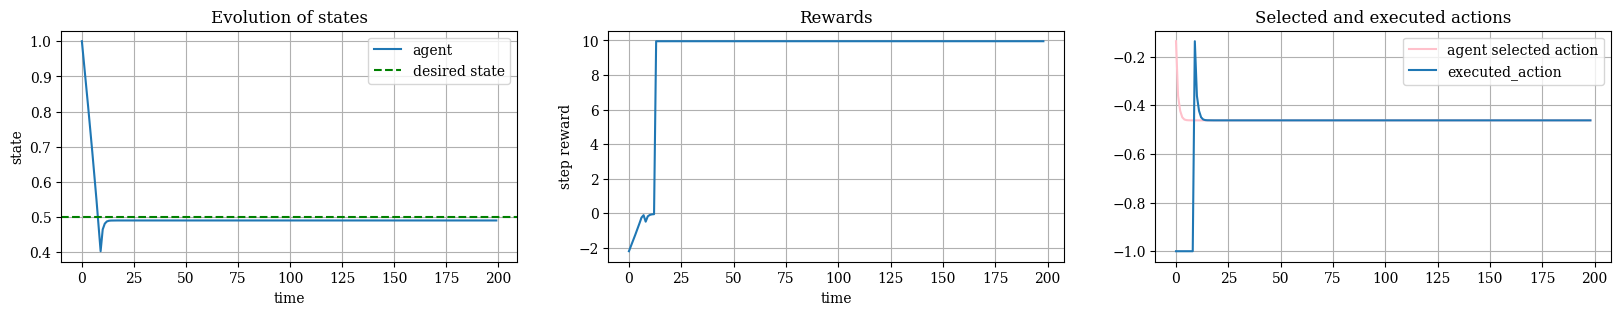

In [91]:
core_env = SphericalTank(desired_state=np.array([0.5]), start_state=np.array([1.0]))
env = init_wrappers(core_env = core_env, observation_type= 'setpoint-error', randomise_setpoint=False)
delay = 9
delayed_env = AugmentState(DelayAction(env, delay = delay), known_delay=10)
env_model  = copy.deepcopy(env)
delay_informed_agent = DelayInformedAgent(undelayed_agent=undelayed_agent,
                                          env_model=env_model, 
                                          init_delay=delay)

states, actions, rewards, avg_rewards, executed = test_agent(delay_informed_agent, env = delayed_env, deterministic=True, state_error=True)
plot_test(delayed_env, states, rewards, actions, executed_actions=executed)

# states, actions, rewards, avg_rewards, executed = test_delayed_agent(undelayed_agent, env = DelayAction(env, delay = delay), env_model = env_model, known_delay = delay, deterministic=True, state_error=True)
# plot_test(delayed_env, states, rewards, actions, executed_actions=executed)

## Transition manager test

Observation space Box(0.0, 4.0, (1,), float64)
Wrapping in observe setpoint error
Delay informed action: [-0.13719052], Safe action: [-0.41191459], Beta: 0.0
Delay informed action: [-0.20051491], Safe action: [-0.83238727], Beta: 0.0
Delay informed action: [0.02448189], Safe action: [-0.77440596], Beta: 0.0
Delay informed action: [0.21967912], Safe action: [-0.60360456], Beta: 0.0
Delay informed action: [0.25491726], Safe action: [-0.72736365], Beta: 0.0
Delay informed action: [0.38230646], Safe action: [-0.86569321], Beta: 0.0
Delay informed action: [0.51239288], Safe action: [-0.38292992], Beta: 0.0
Delay informed action: [0.34446216], Safe action: [-0.6465497], Beta: 0.0
Delay informed action: [0.39217997], Safe action: [-0.37154937], Beta: 0.0
Delay informed action: [0.18892992], Safe action: [-0.27127671], Beta: 0.0
Delay informed action: [-0.07045233], Safe action: [-0.50295538], Beta: 0.0
Delay informed action: [-0.08507651], Safe action: [0.02973688], Beta: 0.0
Delay informed a

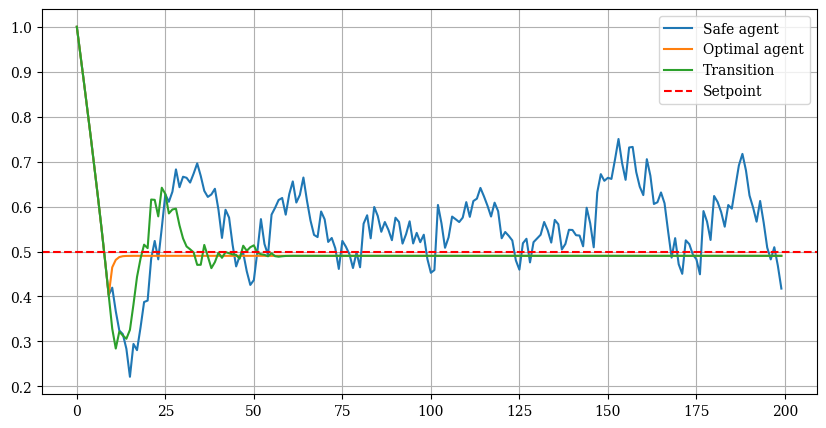

In [41]:
core_env = SphericalTank(desired_state=np.array([0.5]), start_state=np.array([1.0]))
env = init_wrappers(core_env = core_env, observation_type= 'setpoint-error', randomise_setpoint=False)
delay = 9
delayed_env = AugmentState(DelayAction(env, delay = delay), known_delay=10)

manager = TransitionManager(
    delay_informed_agent = delay_informed_agent,
    safe_agent = safe_agent,
    transition_steps = 50, 
    certainty_threshold = 1.0,
)
state_error =  True
seed = 0
deterministic = True
agent = manager

states = []
rewards = []
actions = []
executed_actions = []
avg_rewards = []
delay_certainty = 0
state, done = delayed_env.reset(seed = seed)
# print(f"Initial state was {state}")
episode_reward = 0
t = 0
# Play episode
terminated = truncated = False
while not (terminated or truncated):
    if state_error :
        states.append(delayed_env.unwrapped.state)
    else : 
        states.append(state)
    # if delayed_env.unwrapped.state < 0.6 :
    #      delay_certainty = 1
    action, _ = agent.predict(state, delay_prediction = 9, delay_certainty= delay_certainty, deterministic = deterministic)
    new_state, reward, terminated, truncated, info = delayed_env.step(action)
    executed_action = delayed_env.last_action 
    if (terminated or truncated) : 
            break
    reward = np.array([reward], dtype = float)    
    state = new_state
    episode_reward += reward
    t+= 1
    # Save history
    actions.append(action)
    executed_actions.append(executed_action)
    rewards.append(reward)
    avg_rewards.append(np.mean(rewards[-10:]))     


# plot_test(env, states, rewards, actions, executed_actions=executed_actions) 
f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(states)

core_env = SphericalTank(desired_state=np.array([0.5]), start_state=np.array([1.0]))
env = init_wrappers(core_env = core_env, observation_type= 'setpoint-error', randomise_setpoint=False)
delay = 9
delayed_env = AugmentState(DelayAction(env, delay = delay), known_delay=10)

manager = TransitionManager(
    init_beta=1.0,
    delay_informed_agent = delay_informed_agent,
    safe_agent = safe_agent,
    transition_steps = 50, 
    certainty_threshold = 0.0,
)
state_error =  True
seed = 0
deterministic = True
agent = manager

states = []
rewards = []
actions = []
executed_actions = []
avg_rewards = []
delay_certainty = 0
state, done = delayed_env.reset(seed = seed)
# print(f"Initial state was {state}")
episode_reward = 0
t = 0
# Play episode
terminated = truncated = False
while not (terminated or truncated):
    if state_error :
        states.append(delayed_env.unwrapped.state)
    else : 
        states.append(state)
    # if delayed_env.unwrapped.state < 0.6 :
    #      delay_certainty = 1
    action, _ = agent.predict(state, delay_prediction = 9, delay_certainty= delay_certainty, deterministic = deterministic)
    new_state, reward, terminated, truncated, info = delayed_env.step(action)
    executed_action = delayed_env.last_action 
    if (terminated or truncated) : 
            break
    reward = np.array([reward], dtype = float)    
    state = new_state
    episode_reward += reward
    t+= 1
    # Save history
    actions.append(action)
    executed_actions.append(executed_action)
    rewards.append(reward)
    avg_rewards.append(np.mean(rewards[-10:]))  

ax.plot(states)

core_env = SphericalTank(desired_state=np.array([0.5]), start_state=np.array([1.0]))
env = init_wrappers(core_env = core_env, observation_type= 'setpoint-error', randomise_setpoint=False)
delay = 9
delayed_env = AugmentState(DelayAction(env, delay = delay), known_delay=10)

manager = TransitionManager(
    delay_informed_agent = delay_informed_agent,
    safe_agent = safe_agent,
    transition_steps = 50, 
    certainty_threshold = 0.0,
)
state_error =  True
seed = 0
deterministic = True
agent = manager

states = []
rewards = []
actions = []
executed_actions = []
avg_rewards = []
delay_certainty = 0
state, done = delayed_env.reset(seed = seed)
# print(f"Initial state was {state}")
episode_reward = 0
t = 0
# Play episode
terminated = truncated = False
while not (terminated or truncated):
    if state_error :
        states.append(delayed_env.unwrapped.state)
    else : 
        states.append(state)
    # if delayed_env.unwrapped.state < 0.6 :
    #      delay_certainty = 1
    action, _ = agent.predict(state, delay_prediction = 9, delay_certainty= delay_certainty, deterministic = deterministic)
    new_state, reward, terminated, truncated, info = delayed_env.step(action)
    executed_action = delayed_env.last_action 
    if (terminated or truncated) : 
            break
    reward = np.array([reward], dtype = float)    
    state = new_state
    episode_reward += reward
    t+= 1
    # Save history
    actions.append(action)
    executed_actions.append(executed_action)
    rewards.append(reward)
    avg_rewards.append(np.mean(rewards[-10:]))  

ax.plot(states)
ax.axhline(0.5, color='red', linestyle='--')
ax.legend(['Safe agent','Optimal agent','Transition','Setpoint'])
ax.grid()

## Estimator test for variable delay

In [96]:
core_env = SphericalTank(desired_state=np.array([2.0, 2.0]), max_episode_len=800, seed = 20, start_state=np.array([1.0]))
core_env = init_wrappers(core_env, observation_type='setpoint-error')
env = VariableActionDelay(core_env, max_delay=10, init_delay=0, update_freq=100, delay_type='external', keep_trajectory=True)
safe_agent = SAC.load('models\\SphericalTank\\setpoint-error\\randomised\\Desired3.0\\wcsac.zip')
tank_agent = SAC.load('models\\SphericalTank\\setpoint-error\\randomised\\Desired3.0\\sac.zip')

env = AugmentState(env, known_delay=global_config.MAX_DELAY)

Init: Trajectory [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.

In [127]:

print(f"Env observation space {env.observation_space.shape}")
env_model = copy.deepcopy(core_env)
delay_informed_agent = DelayInformedAgent(undelayed_agent=tank_agent,
                                          env_model=env_model, 
                                          init_delay=0)
estimator = IterativeEstimator(state_shape= env_model.unwrapped.observation_space.shape[0], decay = 0.9, scaling_factor=100)
manager = TransitionManager(
    delay_informed_agent = delay_informed_agent,
    safe_agent = safe_agent,
    transition_steps = 5, 
    certainty_threshold = 0.0,
    noise_level = 0.000
)
estimator.reset()
manager.reset()
# Episode
obs, info = env.reset()
print(f"Initial prediction {estimator.model_errors}, {estimator.get_predicted_delay()}")
# print(f"Initial obs {obs}")
terminated = truncated = False
states = []
delay_preds = []
delay_certainties = []
actions = []
t = 0
while not (terminated or truncated):
    states.append(env.unwrapped.state)
    delay_pred = estimator.get_predicted_delay()
    delay_preds.append(delay_pred)
    delay_certainty = estimator.get_certainty()
    delay_certainties.append(delay_certainty)
    # print(f"At timestep {t} the predicted delay is {delay_pred} with certainty {delay_certainty}")
    # action, _ = safe_agent.predict(obs, deterministic=False)
    if t < 30: 
        action, _ = manager.predict(obs, delay_pred, delay_certainty, deterministic=True)
        # print(action)
    else : 
        action = np.array([0.08536434]) + np.random.normal(0, 0.0001, 1)
    actions.append(action)
    new_obs, reward, terminated, truncated, info = env.step(action)
    estimator.update_errors(env_model, obs, new_obs)
    obs = new_obs
    t += 1

manager = TransitionManager(
    delay_informed_agent = delay_informed_agent,
    safe_agent = safe_agent,
    transition_steps = 10, 
    certainty_threshold = 0.0,
    noise_level = 0.15
)
manager.reset()
estimator.reset()

# Episode
obs, info = env.reset()
print(f"Initial prediction {estimator.model_errors}, {estimator.get_predicted_delay()}")
# print(f"Initial obs {obs}")
terminated = truncated = False
states2 = []
delay_preds2 = []
delay_certainties2 = []
actions2 = []
t = 0
while not (terminated or truncated):
    states2.append(env.unwrapped.state)
    delay_pred = estimator.get_predicted_delay()
    delay_preds2.append(delay_pred)
    delay_certainty = estimator.get_certainty()
    delay_certainties2.append(delay_certainty)
    # print(f"At timestep {t} the predicted delay is {delay_pred} with certainty {delay_certainty}")
    # action, _ = safe_agent.predict(obs, deterministic=False)
    action, _ = manager.predict(obs, delay_pred, delay_certainty, deterministic=True)
    actions2.append(action)
    new_obs, reward, terminated, truncated, info = env.step(action)
    estimator.update_errors(env_model, obs, new_obs)
    obs = new_obs
    t += 1
    


Env observation space (12,)
Initial prediction [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]], 0
Initial prediction [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]], 0


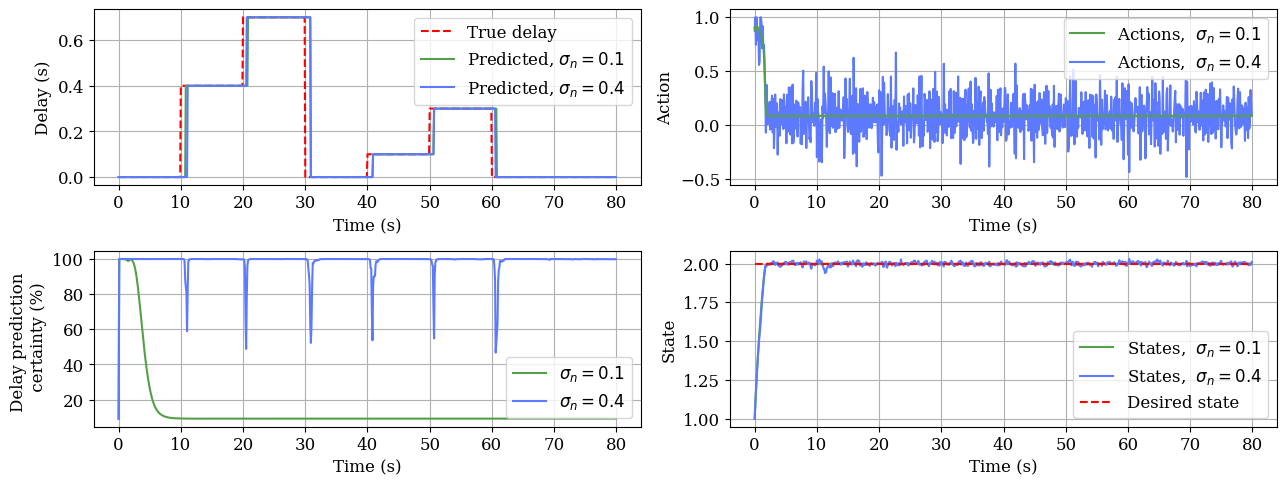

In [128]:
# font size
plt.rcParams['font.size'] = 12
noise_stds = [0.1,0.4]
f, ax = plt.subplots(2,2, figsize = (13, 5))
time_seconds = np.arange(0, len(states)/10, 0.1)
ax[0,0].plot(time_seconds, np.array(env.ep_delay_history)[:len(states)]/10, 'r--')
ax[0,0].plot(time_seconds, np.array(delay_preds)/10, global_config.COLORS['mid_green'])
ax[0,0].plot(time_seconds, np.array(delay_preds2)/10, global_config.COLORS['warm_blue'])
ax[0,0].legend(['True delay', r'Predicted, $\sigma_n = 0.1$', r'Predicted, $\sigma_n = 0.4$'])
ax[0,0].grid()
ax[0,0].set_ylabel('Delay (s)')
ax[0,0].set_xlabel('Time (s)')

ax[1,0].plot(time_seconds,np.array(delay_certainties)*100, global_config.COLORS['mid_green'])
ax[1,0].plot(time_seconds,np.array(delay_certainties2)*100, global_config.COLORS['warm_blue'])
ax[1,0].legend([r'$\sigma_n = 0.1$', r'$\sigma_n = 0.4$']) 
ax[1,0].grid()
ax[1,0].set_ylabel('Delay prediction \n certainty (%)')
ax[1,0].set_xlabel('Time (s)')

ax[0,1].plot(time_seconds,np.array(actions), global_config.COLORS['mid_green'], zorder=3)
ax[0,1].plot(time_seconds,np.array(actions2), global_config.COLORS['warm_blue'], zorder=2)

ax[0,1].legend([r'Actions,  $\sigma_n = 0.1$', r'Actions,  $\sigma_n = 0.4$'])
ax[0,1].grid()
ax[0,1].set_ylabel('Action')
ax[0,1].set_xlabel('Time (s)')

ax[1,1].plot(time_seconds,np.array(states), global_config.COLORS['mid_green'])
ax[1,1].plot(time_seconds,np.array(states2), global_config.COLORS['warm_blue'])
ax[1,1].plot(time_seconds,env.unwrapped.desired_trajectory, 'r' , linestyle = '--')
ax[1,1].legend([r'States,  $\sigma_n = 0.1$', r'States,  $\sigma_n = 0.4$', 'Desired state'])
ax[1,1].grid()
ax[1,1].set_ylabel('State')
ax[1,1].set_xlabel('Time (s)')
f.tight_layout(pad = 1)
